# Web Traffic Time Series Forecasting

**Forecast future traffic to Wikipedia pages**

In [1]:
import numpy as np
import pandas as pd

## Collecting DATA

In [2]:
base_url = '/kaggle/input/web-traffic-time-series-forecasting/'

key_1 = pd.read_csv(base_url+'key_1.csv')
train_1 = pd.read_csv(base_url+'train_1.csv')
sample_submission_1 = pd.read_csv(base_url+'sample_submission_1.csv')

In [3]:
print(train_1.shape, key_1.shape, sample_submission_1.shape)

(145063, 551) (8703780, 2) (8703780, 2)


## Exploratory Data Analisys (EDA)

In [4]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [5]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [6]:
# Creating a list of wikipedia main sites 
sites = ["wikipedia.org", "commons.wikimedia.org", "www.mediawiki.org"]

# Function to create a new column having the site part of the article page
def filter_by_site(page):
    for site in sites:
        if site in page:
            return site

# Creating a new column having the site part of the article page
train_1['Site'] = train_1.Page.apply(filter_by_site)

In [7]:
train_1['Site'].value_counts(dropna=False)

wikipedia.org            127208
commons.wikimedia.org     10555
www.mediawiki.org          7300
Name: Site, dtype: int64

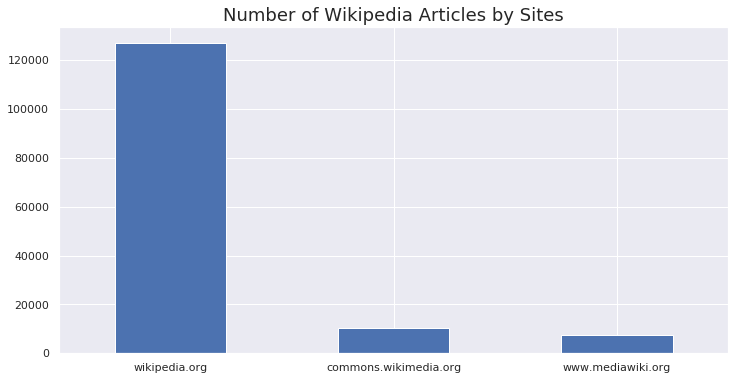

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.figure(figsize=(12, 6))
plt.title("Number of Wikipedia Articles by Sites", fontsize="18")
train_1['Site'].value_counts().plot.bar(rot=0);

In [9]:
# Checking which country codes exist in the article pages
train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,0].str[-3:].value_counts().index.to_list()

['_en', '_ja', '_de', '_fr', '_zh', '_ru', '_es', 'nts', 'der']

In [10]:
# Creating a list of country codes
train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,0].str[-2:].value_counts().index.to_list()[0:7]

['en', 'ja', 'de', 'fr', 'zh', 'ru', 'es']

In [11]:
# Checking which agents + access exist in the article pages and creating a list with them
train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,1].str[1:].value_counts().index.to_list()

['all-access_all-agents',
 'mobile-web_all-agents',
 'all-access_spider',
 'desktop_all-agents']

In [12]:
# Creating the list of country codes and agents
countries = train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,0].str[-2:].value_counts().index.to_list()[0:7]
agents = train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,1].str[1:].value_counts().index.to_list()

# Function to create a new column having the country code part of the article page
def filter_by_country(page):
    for country in countries:
        if "_"+country+"." in page:
            return country

# Creating a new column having the country code part of the article page
train_1['Country'] = train_1.Page.apply(filter_by_country)

# Function to create a new column having the agent + access part of the article page
def filter_by_agent(page):
    for agent in agents:
        if agent in page:
            return agent

# Creating a new column having the agent part of the article page
train_1['Agent'] = train_1.Page.apply(filter_by_agent)

In [13]:
# Understanding what are the NaN values for the Country column
# It seems that the URL page does not contain the country code for those cases

pd.DataFrame(train_1.Page[train_1['Country'].isna() == True]).sample(10)

,Page
15288,Category:Adult_video_arcades_commons.wikimedia...
22721,Meeting_best_practices_(including_remote_staff...
22512,HHVM_www.mediawiki.org_mobile-web_all-agents
82757,File:Standing_jaguar.jpg_commons.wikimedia.org...
45078,Special:UploadWizard_commons.wikimedia.org_all...
81879,Category:Multiple_penetration_commons.wikimedi...
45881,Category:Unidentified_subjects_commons.wikimed...
78405,"File:Handbook_of_ornament;_a_grammar_of_art,_i..."
14513,File:Wiki-standing.png_commons.wikimedia.org_a...
80090,User:Anasserrihani_commons.wikimedia.org_mobil...


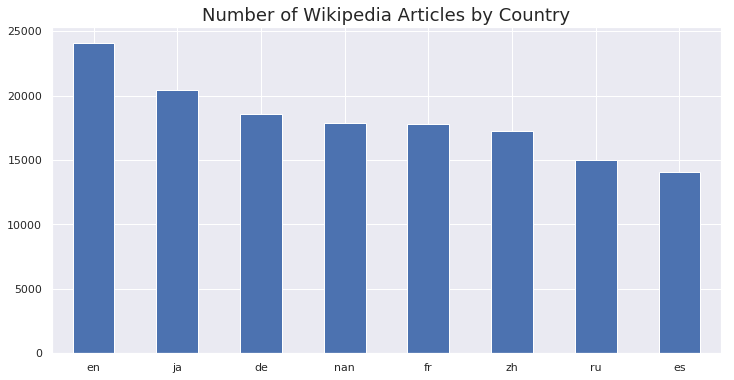

In [14]:
plt.figure(figsize=(12, 6))
plt.title("Number of Wikipedia Articles by Country", fontsize="18")
train_1['Country'].value_counts(dropna=False).plot.bar(rot=0);

In [15]:
train_1['Agent'].value_counts(dropna=False)

all-access_all-agents    39402
mobile-web_all-agents    35939
all-access_spider        34913
desktop_all-agents       34809
Name: Agent, dtype: int64

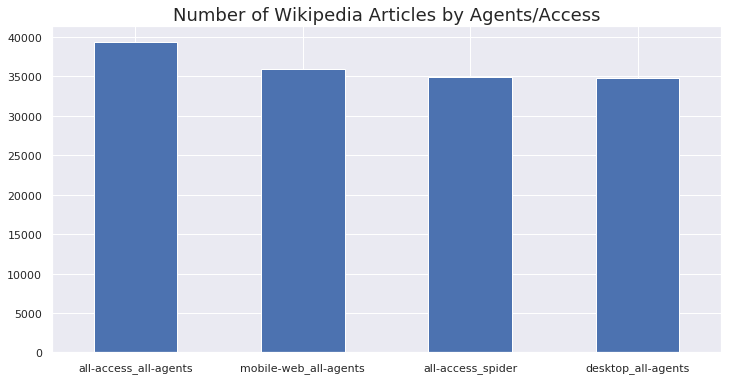

In [16]:
plt.figure(figsize=(12, 6))
plt.title("Number of Wikipedia Articles by Agents/Access", fontsize="18")
train_1['Agent'].value_counts().plot.bar(rot=0);

In [17]:
# Creating a sample dataset from the Train dataset for analysis
train_1_sample = train_1.drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)
train_1_sample

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
83529,Phabricator/Project_management_www.mediawiki.o...,6.0,6.0,4.0,6.0,8.0,6.0,4.0,0.0,2.0,...,6.0,6.0,11.0,4.0,6.0,5.0,7.0,6.0,6.0,9.0
70433,Now_You_See_Me_es.wikipedia.org_desktop_all-ag...,242.0,271.0,309.0,227.0,321.0,311.0,242.0,236.0,243.0,...,231.0,222.0,193.0,229.0,334.0,316.0,324.0,268.0,201.0,190.0
84729,Zürich_Hackathon_2014_www.mediawiki.org_all-ac...,3.0,19.0,19.0,30.0,21.0,24.0,17.0,178.0,40.0,...,6.0,7.0,4.0,8.0,2.0,4.0,9.0,4.0,11.0,12.0
7969,Érythrée_fr.wikipedia.org_desktop_all-agents,672.0,513.0,774.0,1164.0,546.0,755.0,555.0,494.0,4801.0,...,308.0,294.0,358.0,204.0,323.0,438.0,345.0,299.0,306.0,211.0
92077,Metallica_es.wikipedia.org_all-access_all-agents,1534.0,1644.0,1704.0,1569.0,1534.0,1577.0,1608.0,1731.0,1919.0,...,2367.0,2259.0,2229.0,2070.0,2774.0,2552.0,2524.0,2358.0,2291.0,2153.0
142080,Filipinas_es.wikipedia.org_all-access_spider,88.0,58.0,30.0,108.0,71.0,86.0,113.0,50.0,35.0,...,60.0,59.0,29.0,226.0,70.0,49.0,33.0,51.0,33.0,38.0


In [18]:
# Transposing the sample dataset to have Date Time at the index
train_1_sampleT = train_1_sample.drop('Page', axis=1).T
train_1_sampleT.columns = train_1_sample.Page.values
train_1_sampleT.shape

(550, 6)

In [19]:
train_1_sampleT.head()

,Phabricator/Project_management_www.mediawiki.org_all-access_spider,Now_You_See_Me_es.wikipedia.org_desktop_all-agents,Zürich_Hackathon_2014_www.mediawiki.org_all-access_spider,Érythrée_fr.wikipedia.org_desktop_all-agents,Metallica_es.wikipedia.org_all-access_all-agents,Filipinas_es.wikipedia.org_all-access_spider
2015-07-01,6.0,242.0,3.0,672.0,1534.0,88.0
2015-07-02,6.0,271.0,19.0,513.0,1644.0,58.0
2015-07-03,4.0,309.0,19.0,774.0,1704.0,30.0
2015-07-04,6.0,227.0,30.0,1164.0,1569.0,108.0
2015-07-05,8.0,321.0,21.0,546.0,1534.0,71.0


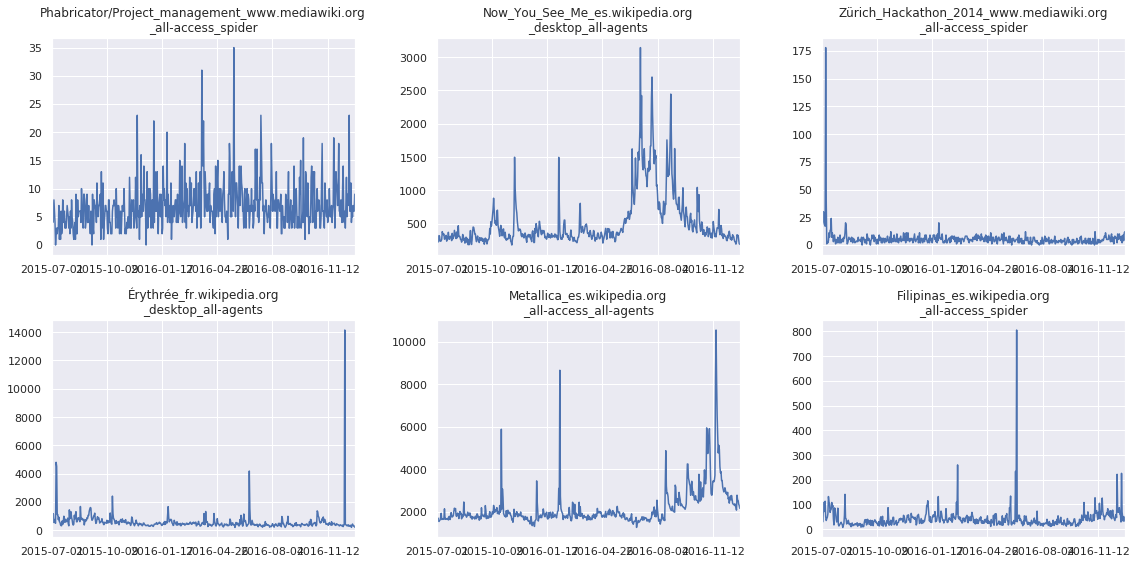

In [20]:
# Plotting the Series from the sample dataset 
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT[v].plot()

plt.tight_layout();

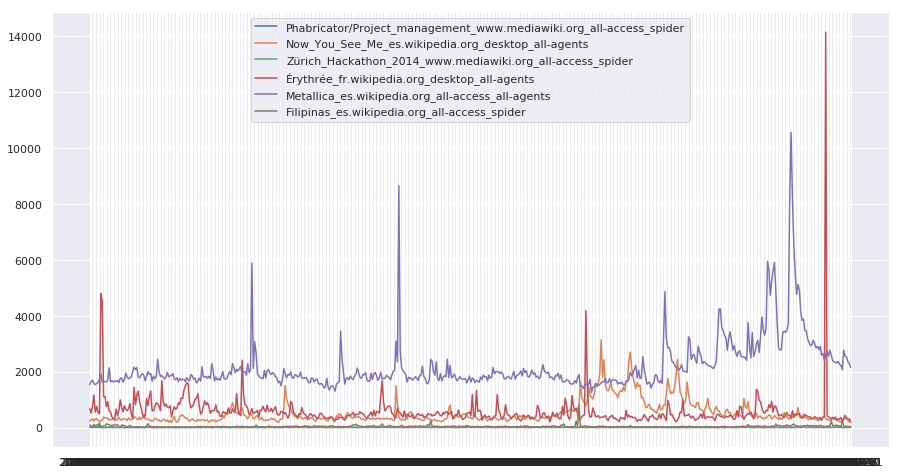

In [21]:
# Plotting the Series from the sample dataset at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT.columns:
    plt.plot(train_1_sampleT[v])
    plt.legend(loc='upper center');

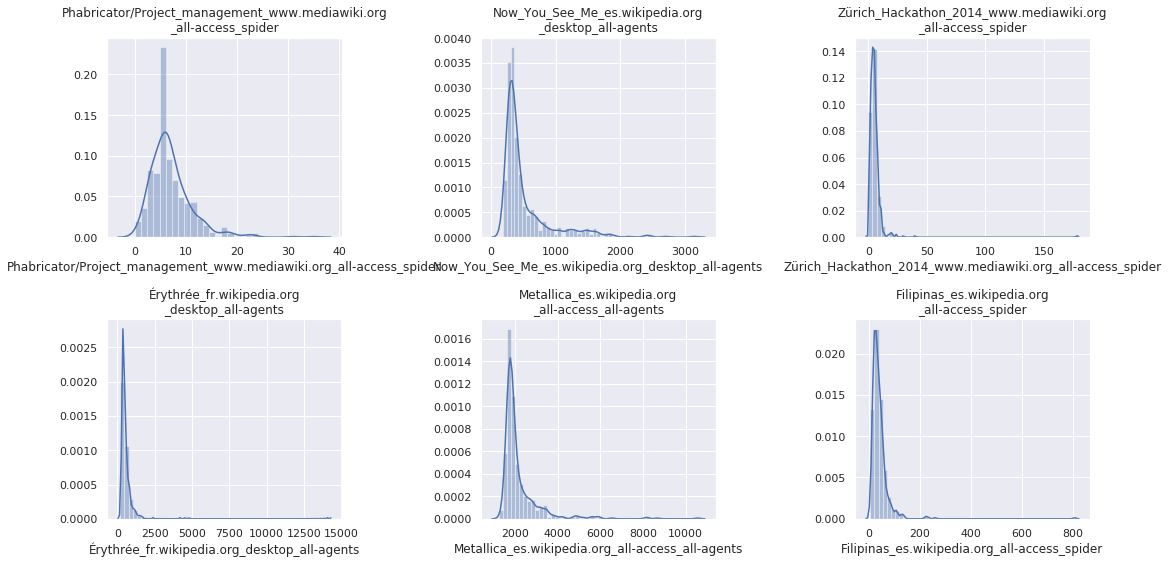

In [22]:
# Plotting the histograms for the Series from the sample dataset
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    sns.distplot(train_1_sampleT[v])

plt.tight_layout();

In [23]:
# Checking that the number of visits to the Wikipedia Articles have Gaussian Distribution (p-value=0)
from scipy.stats import kstest, ks_2samp

pages = list(train_1_sampleT.columns)

print("Kolgomorov-Smirnov - Normality Test")
print()

for p in pages:
    print(p,':', kstest(train_1_sampleT[p], 'norm', alternative = 'less'))    

Kolgomorov-Smirnov - Normality Test

Phabricator/Project_management_www.mediawiki.org_all-access_spider : KstestResult(statistic=0.9536135044154571, pvalue=0.0)
Now_You_See_Me_es.wikipedia.org_desktop_all-agents : KstestResult(statistic=1.0, pvalue=0.0)
Zürich_Hackathon_2014_www.mediawiki.org_all-access_spider : KstestResult(statistic=0.8972498680518208, pvalue=0.0)
Érythrée_fr.wikipedia.org_desktop_all-agents : KstestResult(statistic=1.0, pvalue=0.0)
Metallica_es.wikipedia.org_all-access_all-agents : KstestResult(statistic=1.0, pvalue=0.0)
Filipinas_es.wikipedia.org_all-access_spider : KstestResult(statistic=0.9999999999987201, pvalue=0.0)


**Conclusion:** the results shows p-values equals to zero, hence visits to the wikipedia articles for the extracted sample have normal distributions.

### Exploring Groups of Time Series for Different Sites     

In [24]:
# List of the main Wikipedia Article sites
sites

['wikipedia.org', 'commons.wikimedia.org', 'www.mediawiki.org']

In [25]:
# Creating sample datasets from the train dataset and filtering them by sites
train_1_sample_site0 = train_1[train_1['Site'] == sites[0]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)
train_1_sample_site1 = train_1[train_1['Site'] == sites[1]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)
train_1_sample_site2 = train_1[train_1['Site'] == sites[2]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)

# Transposing them to have the Date Time as index
train_1_sampleT_site0 = train_1_sample_site0.drop('Page', axis=1).T
train_1_sampleT_site0.columns = train_1_sample_site0.Page.values
train_1_sampleT_site1 = train_1_sample_site1.drop('Page', axis=1).T
train_1_sampleT_site1.columns = train_1_sample_site1.Page.values
train_1_sampleT_site2 = train_1_sample_site2.drop('Page', axis=1).T
train_1_sampleT_site2.columns = train_1_sample_site2.Page.values

**Time Series of "WIKIPEDIA.ORG" sites only**

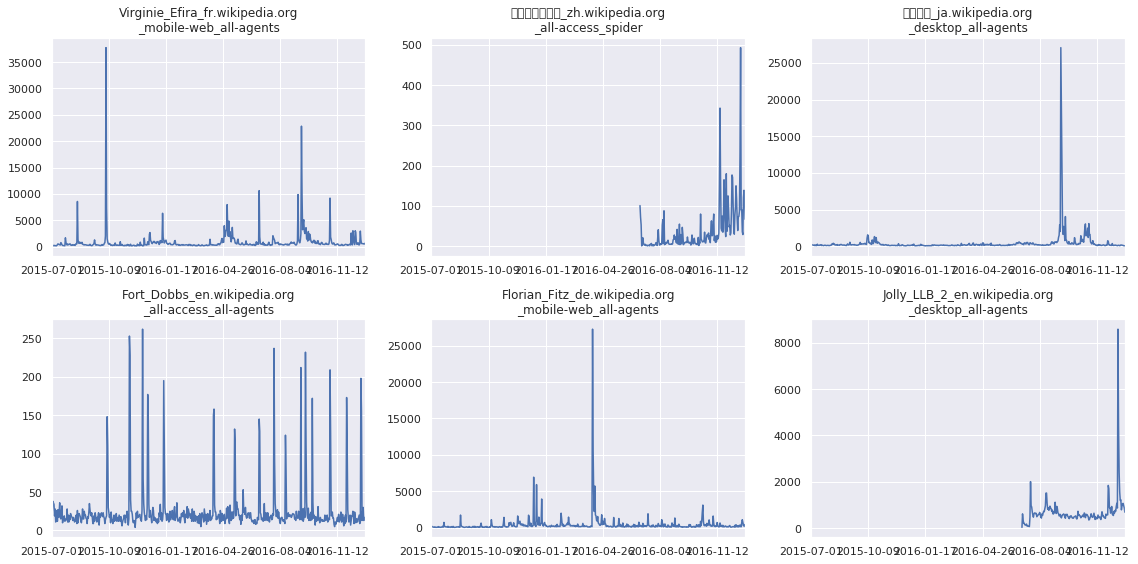

In [26]:
# Plotting the Series from the sample datasets
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_site0.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_site0[v].plot()

plt.tight_layout();

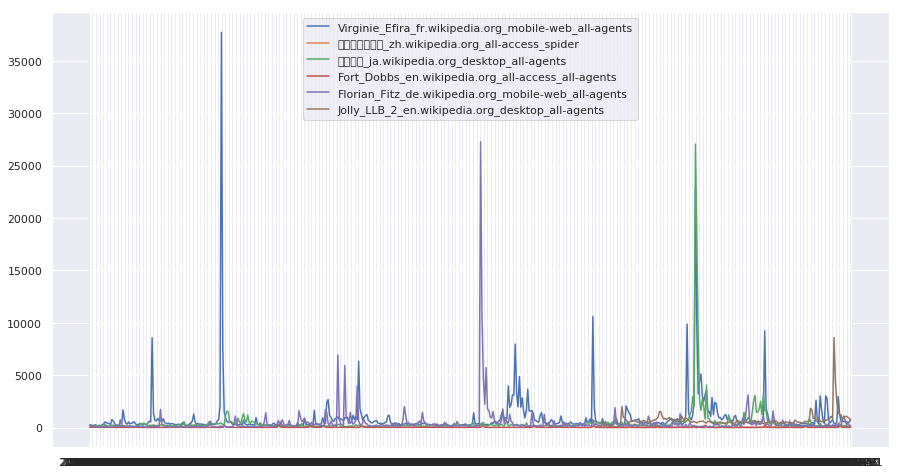

In [27]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_site0.columns:
    plt.plot(train_1_sampleT_site0[v])
    plt.legend(loc='upper center');

**Time Series of "COMMONS.WIKIMEDIA.ORG" sites only**

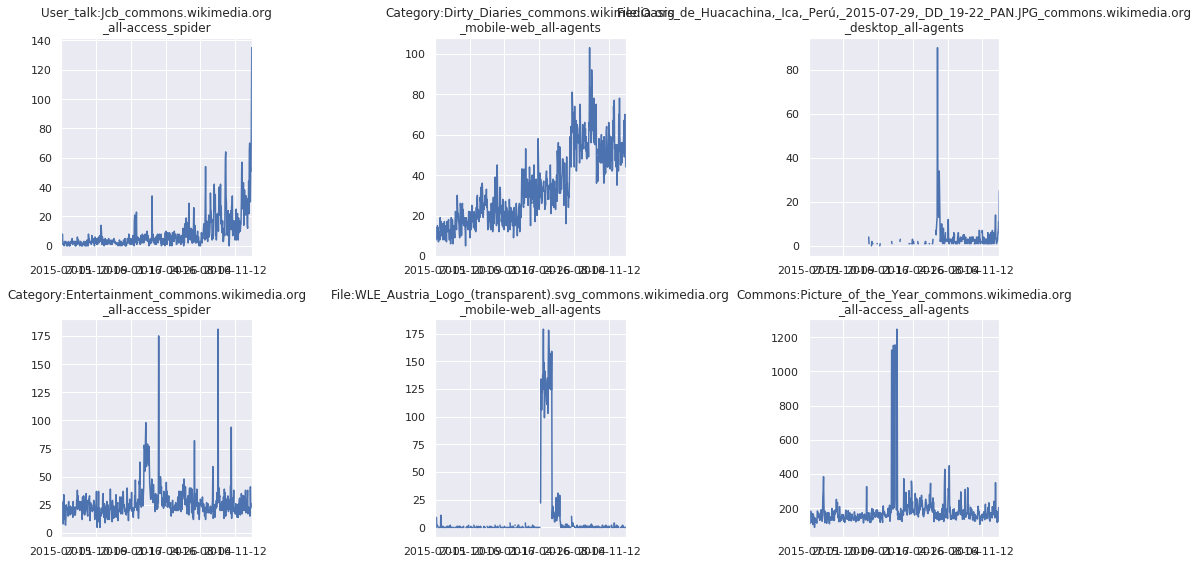

In [28]:
# Plotting the Series from the sample datasets
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_site1.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_site1[v].plot()

plt.tight_layout();

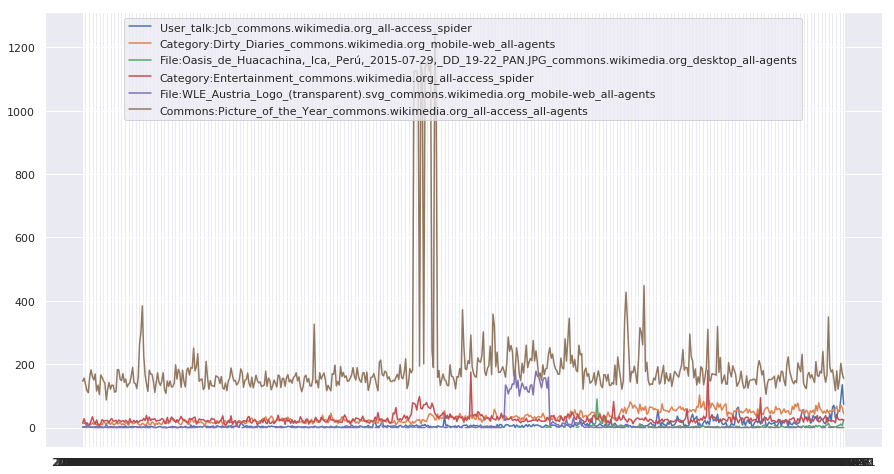

In [29]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_site1.columns:
    plt.plot(train_1_sampleT_site1[v])
    plt.legend(loc='upper center');

**Time Series of "WWW.MEDIAWIKI.ORG" sites only**

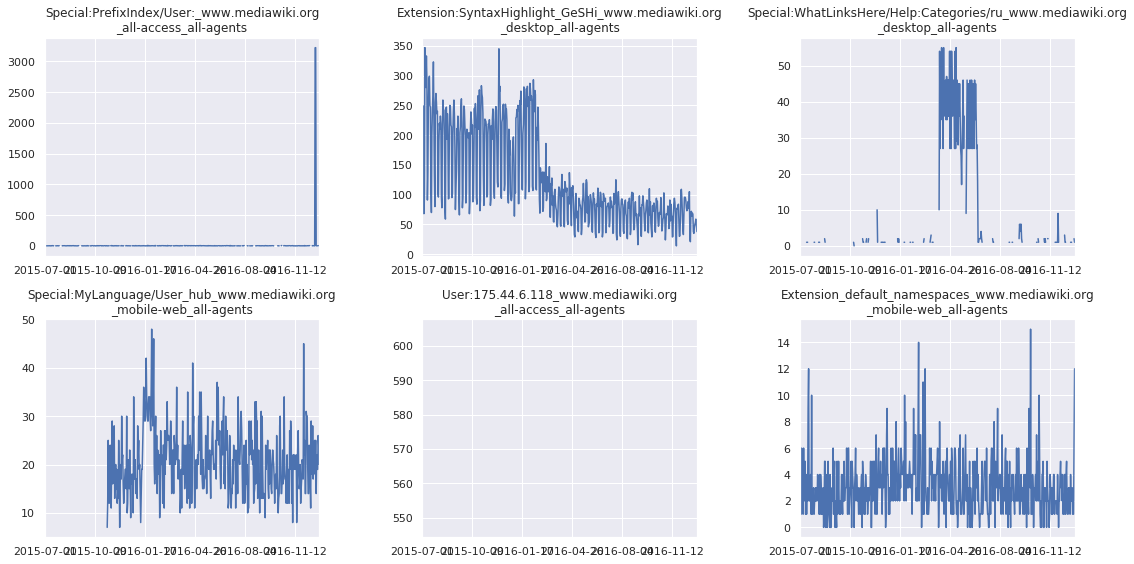

In [30]:
# Plotting the Series from the sample datasets
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_site2.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_site2[v].plot()

plt.tight_layout();

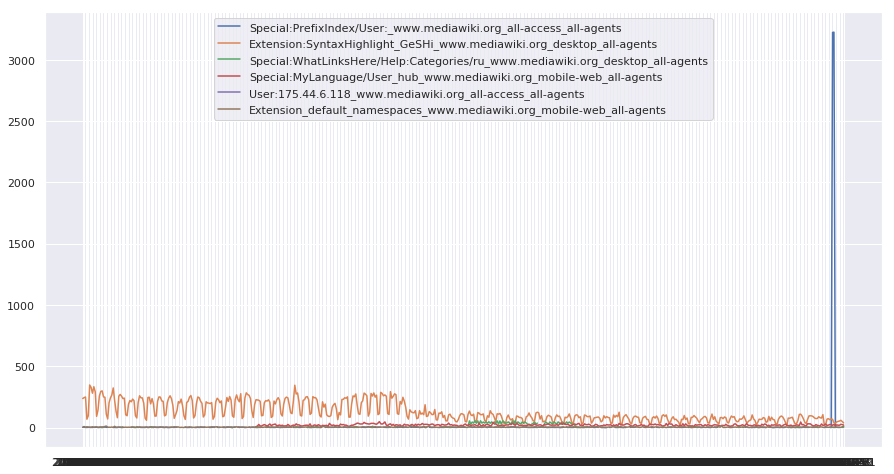

In [31]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_site2.columns:
    plt.plot(train_1_sampleT_site2[v])
    plt.legend(loc='upper center');

In [32]:
train_1_sampleT_site2.columns[4]

'User:175.44.6.118_www.mediawiki.org_all-access_all-agents'

Notes:

For all the sites samples, some series presented missing data (NaNs).

For one of the WWW.MEDIAWIKI.ORG Series sample, noticed there was no data at all.  
For this series, the URL contains the IP address instead of DNS name and it starts with "User:"

### Exploring a Group of Time Series for a Specific Country - DE

In [33]:
# List of the Wikipedia Article country codes
countries

['en', 'ja', 'de', 'fr', 'zh', 'ru', 'es']

In [34]:
# Creating a sample dataset from the train dataset for countries having "de" code
train_1_sample_de = train_1[train_1['Country'] == countries[2]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)

# Transposing the sample dataset to have Date Time at the index
train_1_sampleT_de = train_1_sample_de.drop('Page', axis=1).T
train_1_sampleT_de.columns = train_1_sample_de.Page.values

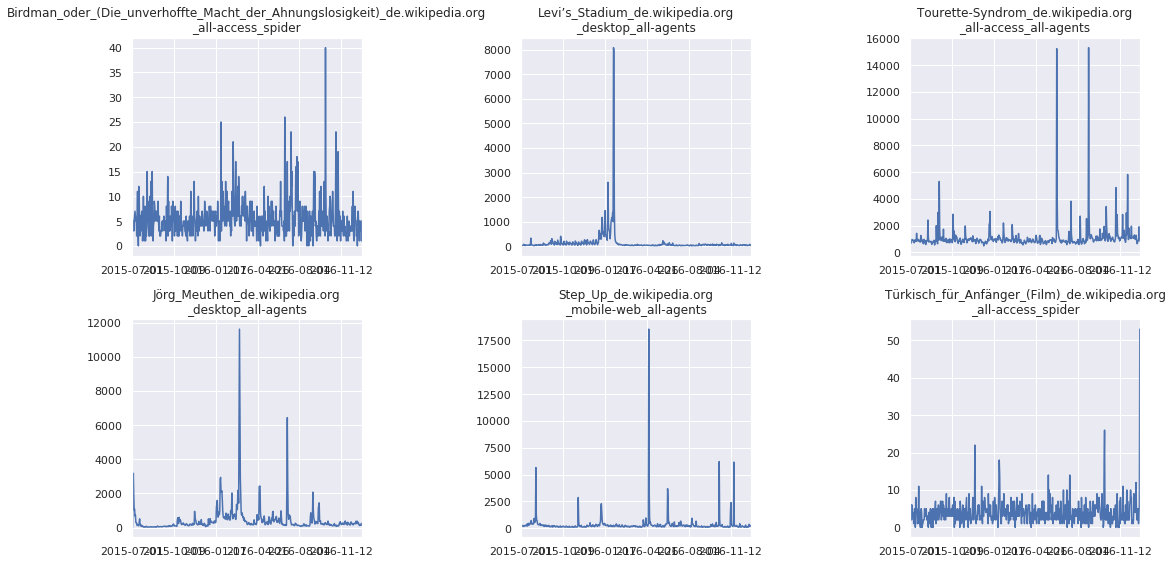

In [35]:
# Plotting the Series from the sample dataset
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_de.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_de[v].plot()

plt.tight_layout();

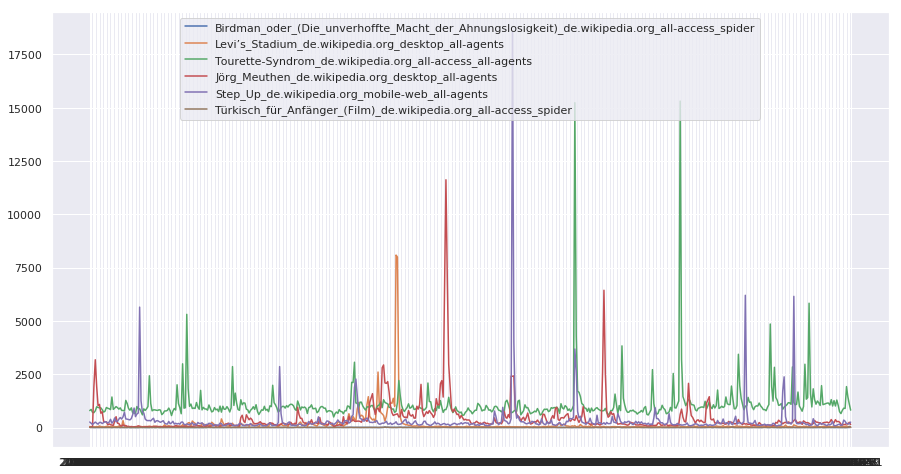

In [36]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_de.columns:
    plt.plot(train_1_sampleT_de[v])
    plt.legend(loc='upper center');

## Feature Engineering

### Time Series - Lags

In [37]:
# Picked up one Time Series for the prophet modeling
train_1_sampleT.columns[1]

'Now_You_See_Me_es.wikipedia.org_desktop_all-agents'

In [38]:
# Creating a dataframe for the Time Series from the train_1 samples dataset
data = pd.DataFrame(train_1_sampleT.iloc[:,1].copy())
data.columns = ['y']
data.head()

,y
2015-07-01,242.0
2015-07-02,271.0
2015-07-03,309.0
2015-07-04,227.0
2015-07-05,321.0


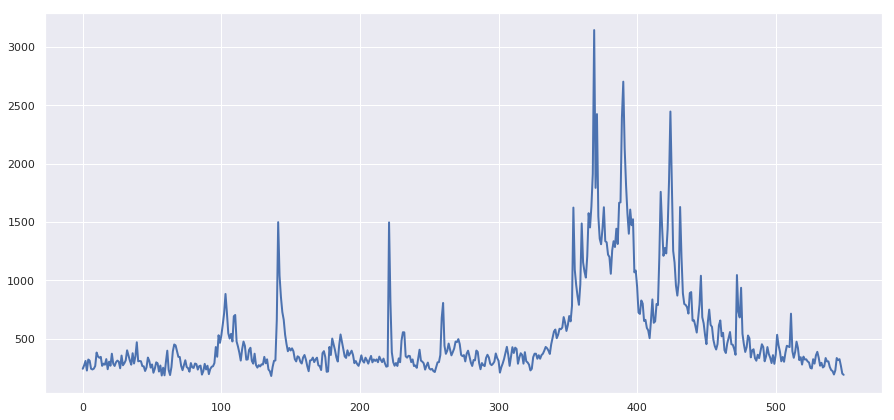

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(data.y.values, label="actual", linewidth=2.0);

In [40]:
# Adding the lag of the target variable from 1 step back up to 7
for i in range(1, 8):
    data["lag_{}".format(i)] = data.y.shift(i)

In [41]:
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2016-12-27,316.0,334.0,229.0,193.0,222.0,231.0,257.0,305.0
2016-12-28,324.0,316.0,334.0,229.0,193.0,222.0,231.0,257.0
2016-12-29,268.0,324.0,316.0,334.0,229.0,193.0,222.0,231.0
2016-12-30,201.0,268.0,324.0,316.0,334.0,229.0,193.0,222.0
2016-12-31,190.0,201.0,268.0,324.0,316.0,334.0,229.0,193.0


## Modeling with Machine Learning

### Train Test Split

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 

In [43]:
# for time-series cross-validation set 3 folds
# ~180 days by fold from total of 550 days
tscv = TimeSeriesSplit(n_splits=3)

In [44]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [45]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 33% of data for testing
# so test size would be ~180 days
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.33)

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(363, 7) (363,) (180, 7) (180,)


### Linear Regression

* First we need to define the evaluation metric functions.

**MAPE - Mean Absolute Percentage Error:**

$$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$$

**SMAPE - Symmetric Mean Absolute Percentage Error:**

$$ SMAPE = \frac{100\%}{n} \sum_{t=1}^{n} \frac{\left|F_t - A_t\right|}{(\left|A_t\right|+\left|F_t\right|)/2} $$

In [47]:
# Function for the MAPE error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function for the SMAPE error
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

Below are the function to plot the Model results and its coeficients.

In [48]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    mape_error = mean_absolute_percentage_error(prediction, y_test)
    smape_error = smape(prediction, y_test)
    plt.title("MAPE: "+str(mape_error)+"\n"+"SMAPE: "+str(smape_error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Running the Linear Regression Model.

In [49]:
from sklearn.linear_model import LinearRegression

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Plotting the results.

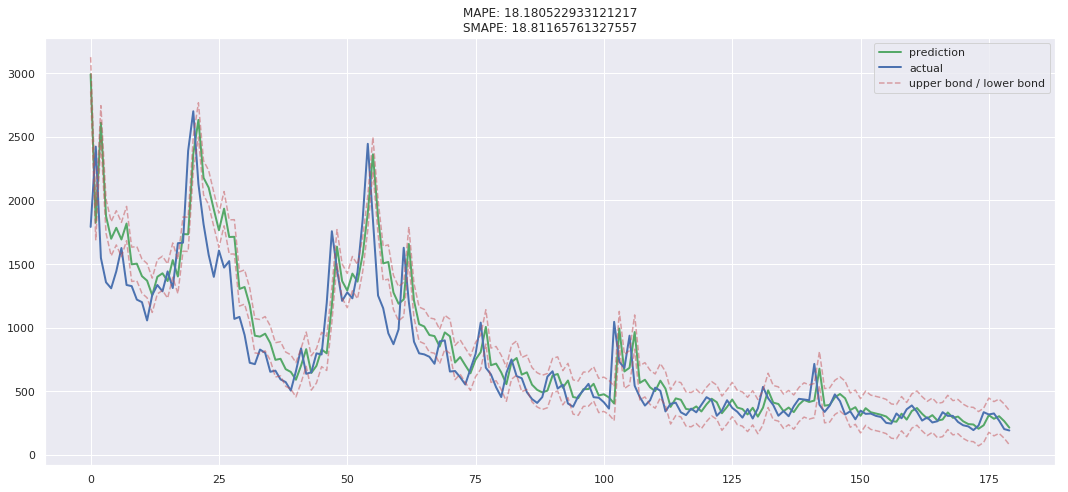

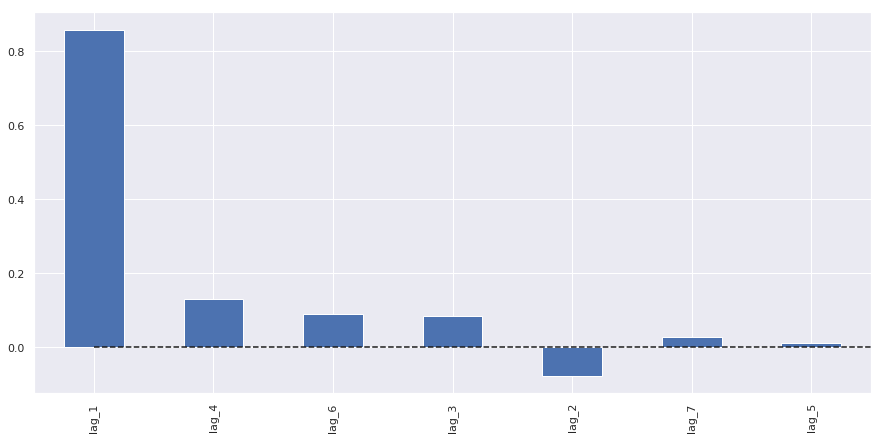

In [50]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

## Aditional Feature Engineering

In [51]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,weekday,is_weekend
2016-12-25,229.0,193.0,222.0,231.0,257.0,305.0,305.0,334.0,6,1
2016-12-26,334.0,229.0,193.0,222.0,231.0,257.0,305.0,305.0,0,0
2016-12-27,316.0,334.0,229.0,193.0,222.0,231.0,257.0,305.0,1,0
2016-12-28,324.0,316.0,334.0,229.0,193.0,222.0,231.0,257.0,2,0
2016-12-29,268.0,324.0,316.0,334.0,229.0,193.0,222.0,231.0,3,0
2016-12-30,201.0,268.0,324.0,316.0,334.0,229.0,193.0,222.0,4,0
2016-12-31,190.0,201.0,268.0,324.0,316.0,334.0,229.0,193.0,5,1


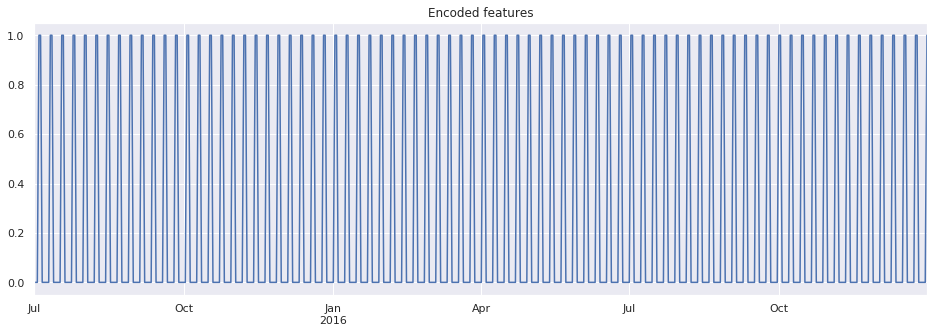

In [52]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
#data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

### Scaling Data

After adding "weekday" and "is_weekend" features, we have different scales in data values.  

Hence, we need to tranform data to the same scale to continue the analysis.

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [54]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.33)

In [55]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(363, 9) (363,) (180, 9) (180,)


In [56]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
print(X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape)

(363, 9) (363,) (180, 9) (180,)


## Linear Regression Model plus Additional Features

In [58]:
# Linear Regression using Scaled Data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Plotting the results

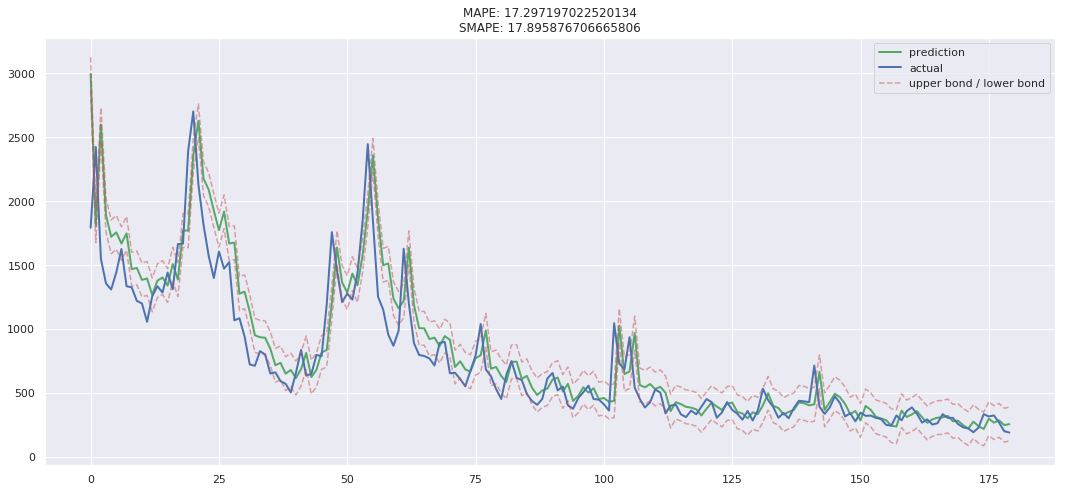

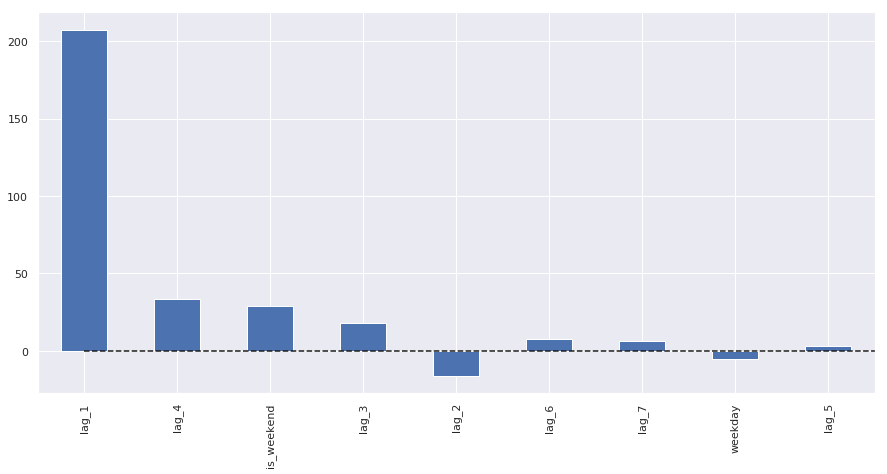

In [59]:
plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

**Conclusion:**  

The MAPE and SMAPE errors decreased a litte bit, from 18.18% and 18.81% to 17.30% and 17.90%.  

Also the "**is_weekend**" added feature showed up as useful resource, while the "**weekday**" added feature not contributed so much. 

## Regularization - Ridge and Lasso

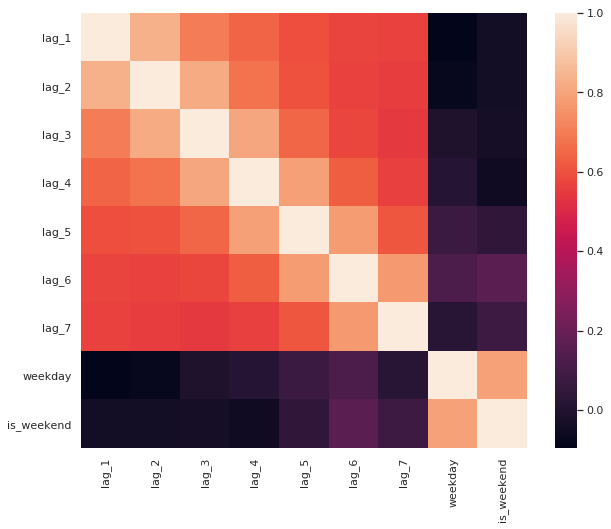

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

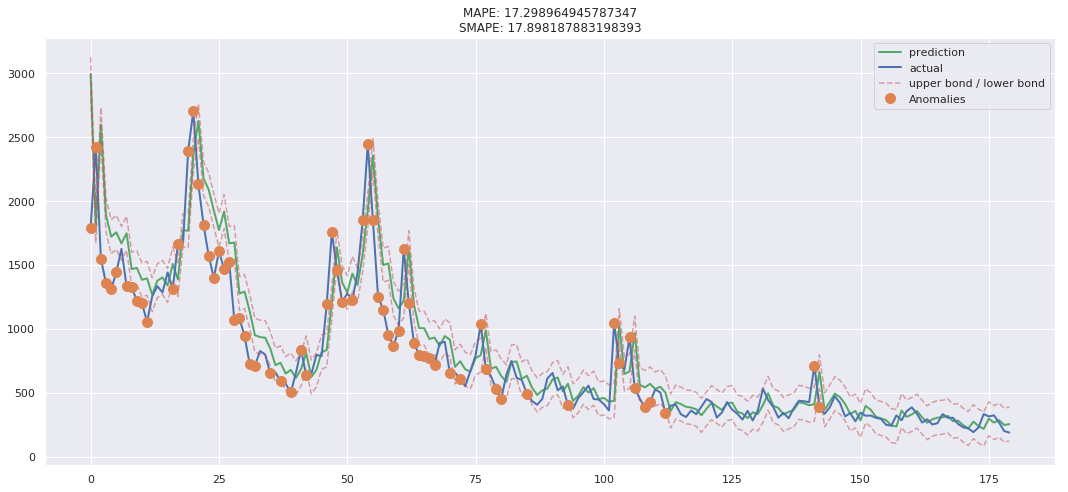

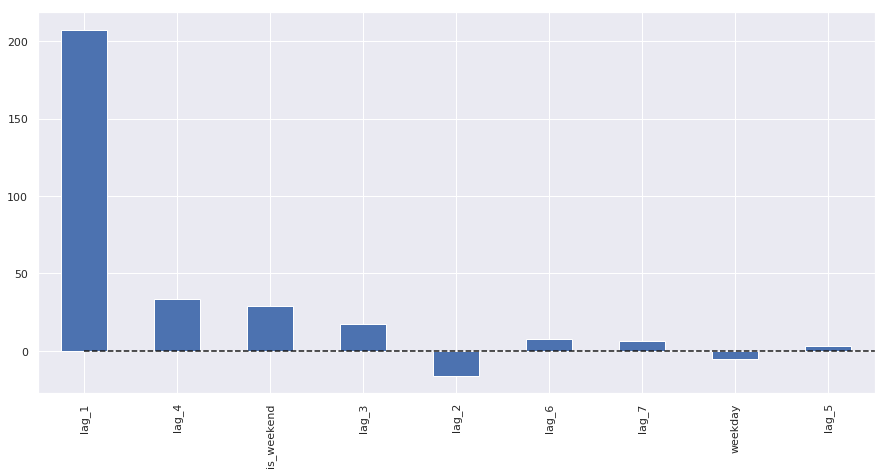

In [61]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

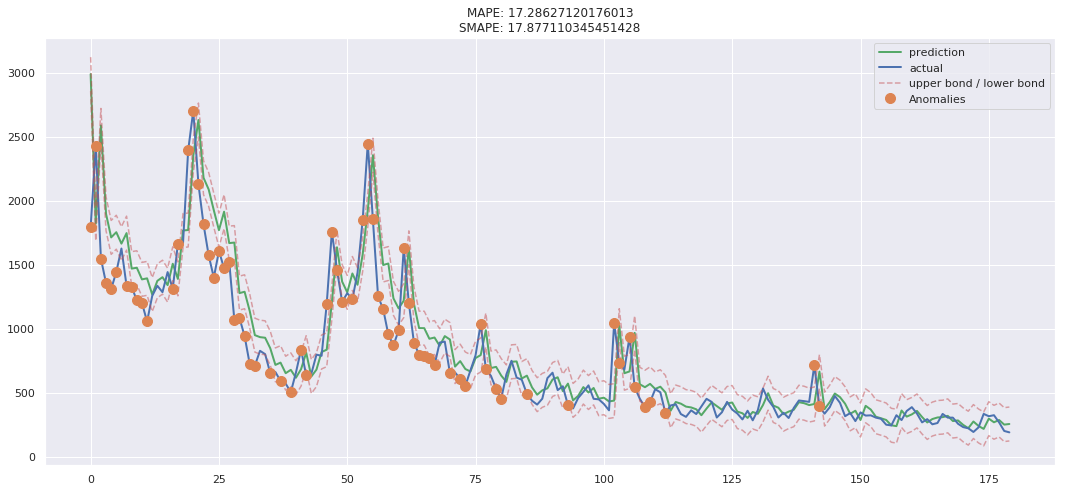

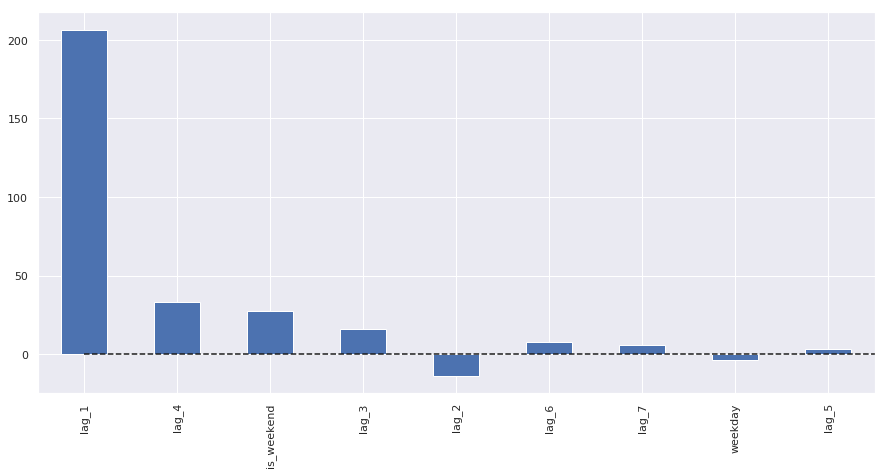

In [62]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

**Conclusion:**

Regularization did not change neither helped to improve the results in this case.

## Modeling with XGboost

In [63]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train);

[21:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


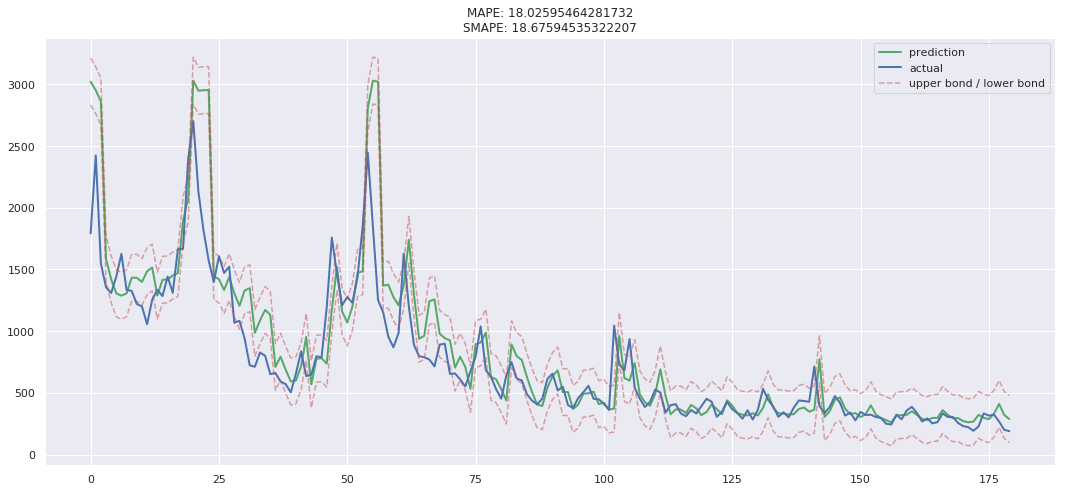

In [64]:
plotModelResults(xgb, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)

**Conclusion:**

The MAPE and SMAPE errors were a litte bit bigger, increasing from 17.30% and 17.90% to 18.03% and 18.68%.

### Prediction for the next 60 days

In [65]:
# Creating a dataframe for the Time Series from the train_1 samples dataset
data = pd.DataFrame(train_1_sampleT.iloc[:,1].copy())
data.columns = ['y']
data.index = pd.to_datetime(data.index)
future = pd.DataFrame(index=pd.date_range(start='2017-01-01', end='2017-03-01'), columns=data.columns).fillna(0)
data_future = data.append(future)

In [66]:
for i in range(1, 61):
    data_future["lag_{}".format(i)] = data_future.y.shift(i)

data_future["weekday"] = data_future.index.weekday
data_future['is_weekend'] = data_future.weekday.isin([5,6])*1
data_future.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,weekday,is_weekend
2017-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,190.0,201.0,268.0,324.0,316.0,334.0,229.0,3,0
2017-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,190.0,201.0,268.0,324.0,316.0,334.0,4,0
2017-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,190.0,201.0,268.0,324.0,316.0,5,1
2017-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,190.0,201.0,268.0,324.0,6,1
2017-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,190.0,201.0,268.0,0,0
2017-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,190.0,201.0,1,0
2017-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.0,2,0


In [67]:
data_future.shape

(610, 63)

In [68]:
X_train = data_future.iloc[:550,:].dropna().drop(['y'], axis=1)
y_train = data_future.iloc[:550,:].dropna().y

X_test = data_future.iloc[550:,:].dropna().drop(['y'], axis=1)
y_test = data_future.iloc[550:,:].dropna().y

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(490, 62) (490,) (60, 62) (60,)


In [69]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
prediction = lr.predict(X_test)

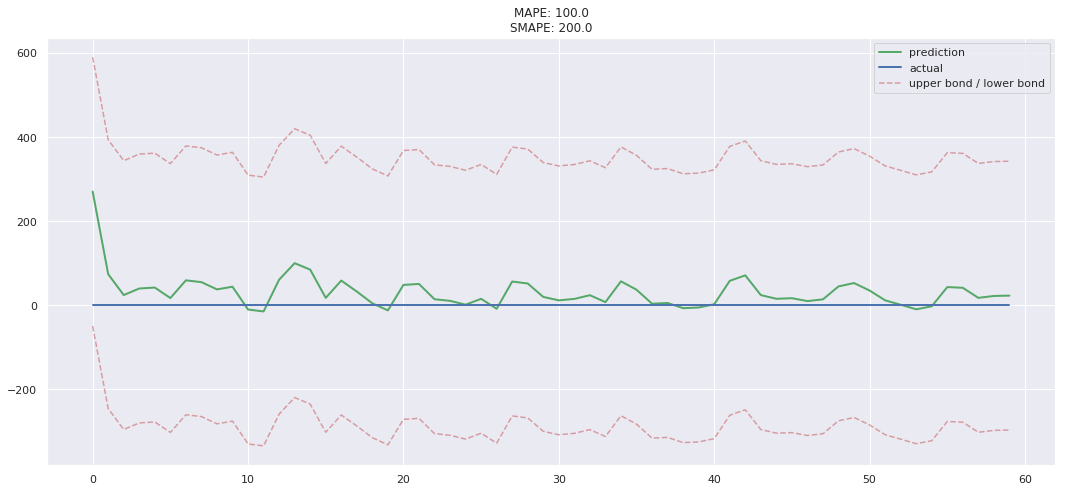

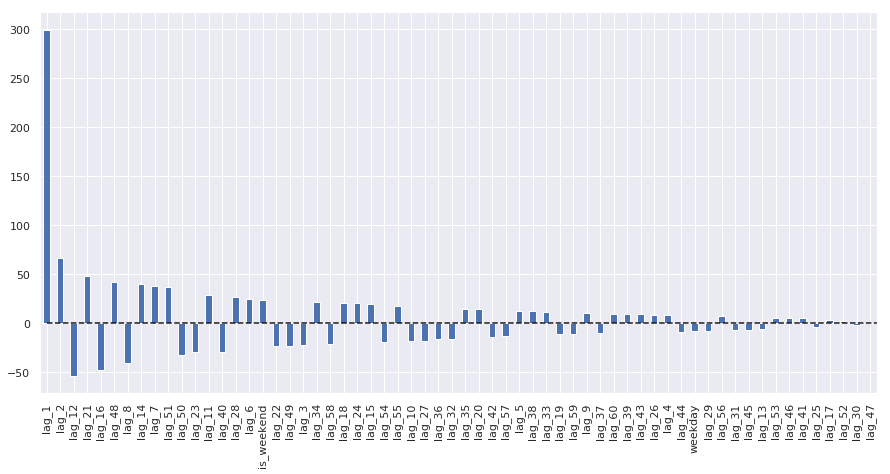

In [72]:
plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

## Multivariate Time Series models

I could be using Multivariate Time Series (MTS) instead of the univariate models against all Time Series.  
Following this approach, below are some ideas I could try in the future:

- Vector Auto Regression (VAR)
  - Johansen’s test for checking the stationarity of any multivariate time series data  
    (statsmodels.tsa.vector_ar.vecm import coint_johansen)
  - Fit the model using VAR model from statsmodel library  
    (from statsmodels.tsa.vector_ar.var_model import VAR)  
- Random Forest  
- Recurrent Neural Networs (RNN)  

Sources:  

<a href="https://link.medium.com/miaEiLC0c1">A Multivariate Time Series Guide to Forecasting and Modeling (with Python codes)</a>)  
<a href="https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1">Multivariate Time Series Forecasting Using Random Forest</a>)  
<a href="https://link.medium.com/XFbTA4O0c1">Interpreting recurrent neural networks on multivariate time series</a>

## Multiple Time Series in parallel  

Another idea could be the use of Python multiprocessing package to forecast multiple Time Series in parallel.  

Source:  

<a href="https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245">Forecasting multiple time-series using Prophet in parallel</a>

## Submitting to Kaggle

In [73]:
# train_1_sampleT.columns[1]+"_"+"2017-01-01"
# train_1_sampleT.columns[1]+"_"+"2017-01-01" in list(key_1.Page.values)